## Natural Language Processing (NLP) Application to Energy Industry Articles

This notebook demonstrate how to create a word vector dictionary for vocabulary in energy industry <br>
and analyze the article trend using NLP and PCA.

### Import Libraries

In [1]:
import os
import re
import copy
import string
import operator
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pyl
from collections import Counter,OrderedDict
from datetime import datetime
from dateutil import parser
from calendar import month_name
import PyPDF2
from english_spelling import replace_gb2us
import nltk
_ = nltk.download('wordnet', quiet=True)
from nltk.stem.wordnet import WordNetLemmatizer

### Functions for text preprocessing

In [2]:
def preprocessing(text_list):
    '''
    Convert a list of strings into a single body text.
    Exclude several specified words.
    '''
    
    # In case text.split('\n') does not work, create a list of words
    if len(max(text_list, key=len)) > 100 and len(text_list) < 35:
        text_list = ' '.join(text_list).split()
    
    # Useless word list
    exclude = ['Page', 'Executive summary', 'Key take-aways:','Summary']
    filter_func = lambda s: not any(x in s for x in exclude) and len(s) > 1
    text_list = [line.replace("'",'') for line in text_list if filter_func(line)]
    
    body_text = ' '.join(text_list)
    return body_text,flag

In [3]:
def del_some_chars(body_text):
    ''' Delete symbols '''
    char_exclude = [',', '.','--','-','+','!','?',':',';','"','(',')',']','[',
                    '@','^','*','>','<','`','%','$','/']
    body_text = ''.join([s for s in body_text if s not in set(char_exclude)])
    return body_text

In [4]:
def del_non_ascii(body_text):
    ''' Delete non-ascii characters '''
    printable = set(string.printable)
    body_text = ''.join(filter(lambda x: x in printable, body_text))
    body_text = re.sub(' +', ' ', body_text)
    return body_text

In [5]:
def appleOrange(body_text):
    ''' Split 'appleOrange' to 'apple' and 'Orange' '''
    word_list = body_text.split(' ')
    for i, line in enumerate(word_list):        
        try:
            r1 = re.findall('([A-Z][a-z]+)',line)[-1]
            r2 = line.replace(r1, '')
            word_list[i] = r2 + ' ' + r1
        except:
            pass;
    body_text = ' '.join(word_list)[1:]
    return body_text

In [6]:
def date_finder(body_text):
    ''' Extract Date from body text '''
    
    s = body_text[0:100]
    
    # Extract Month
    pattern = '|'.join(month_name[1:])
    month = re.search(pattern, s, re.IGNORECASE).group(0)
    
    # Extract Year
    year = re.search(r'\d{4}', s).group()
    date_str = ' '.join([month,year])
    date = datetime.strptime(date_str,'%B %Y')
    ymd_str = datetime.strftime(date,'%Y/%m/%d')
    
    body_text = body_text.replace(month + ' ' + year + ' ', '')
    return body_text, ymd_str

In [7]:
def tokenizer(body_text):
    ''' Convert verbs to at its present tense, plural nouns to singular '''
    word_list = body_text.split(' ')
    word_list = [WordNetLemmatizer().lemmatize(word,'v') for word in word_list]   # Convert verbs to present tense
    word_list = [WordNetLemmatizer().lemmatize(word,'n') for word in word_list]   # Convert plural to singular
    word_list = [WordNetLemmatizer().lemmatize(word,'a') for word in word_list]   # Adjective
    word_list = [WordNetLemmatizer().lemmatize(word,'r') for word in word_list]   # Adverb    
    word_list = [word for word in word_list if not re.search(r'\d',word)]         # Remove words that contain a number
    word_list = [word for word in word_list if len(word) < 10 and len(word) > 1]  # Remove too short/long words
    body_text = ' '.join(word_list)
    return body_text

In [8]:
def pdf_parser(path_file):
    ''' Parser '''
    pdfReader = PyPDF2.PdfFileReader(open(path_file, 'rb'))  # Read a PDF file

    text = ''
    for i in range(pdfReader.numPages):
        # Extract text from a page object        
        pageObj = pdfReader.getPage(i)
        text_tmp = pageObj.extractText()

        # Append text on every page
        if i == 0:
            text += text_tmp
        else:
            text += '\n'.join(text_tmp.split('\n')[1:])  # Append text on every page
            
        text_list = text.split('\n')
        body_text, flag = preprocessing(text_list)   # Preprocessing from text list
        body_text = del_some_chars(body_text)        # Delete some characters
        body_text, ymd_str = date_finder(body_text)  # Extract Date
        body_text = del_non_ascii(body_text)         # Delete non-ascii characters
        body_text = appleOrange(body_text)           # Split overlapping word into single words
        body_text = body_text.lower()                # Convert all the text into lower case
        body_text = replace_gb2us(body_text)         # Replace British English with American English 
        body_text = tokenizer(body_text)             # Tokenizer
    return body_text, ymd_str, flag

<br>
<br>
<br>
<br>
<br>

### Read PDF files, pre-process text files, and save them.

In [9]:
def preprocess_pdfs(path_input,path_output):
    ''' Load PDF files and pre-process texts and save them in ascii files '''
    article_list = []
    for root, dirs, files in os.walk(path_input):
        Group = root.split('/')[-2]
        SubGroup = root.split('/')[-1]
        idx = 0
        for file in files:
            if file.endswith('.pdf'):
                # Extract body text and Issue Date
                path_file = os.path.join(root,file)
                try:
                    body_text, ymd_str, flag = pdf_parser(path_file)
                except:
                    body_text, ymd_str, flag = '', '0000/00/00', 0
                    pass;

                # Record Article Information and append it in a dictionary            
                Title = path_file.split('/')[-1].replace('.pdf','')
                dict_add = OrderedDict({'Group':Group,'SubGroup':SubGroup,'Date':ymd_str,'Title':Title,
                                        'Length Body Text':len(body_text),'HelpDesk':flag})
                article_list.append(dict_add)

                idx += 1
                filename = Group+'_'+SubGroup+'_'+str(idx)+'_'+ymd_str.replace('/','.')+'.txt'
                path_output_file = os.path.join(path_output, filename)
                with open(path_output_file,'w') as file:
                    file.write(body_text)
    # Save Preprocessing Results
    df = pd.DataFrame(article_list)
    df.to_csv('./article_summary.csv',index=False)

In [10]:
path_input = './articles_pdf'
path_output = './articles_text'
preprocess_pdfs(path_input,path_output)

### Load pre-processed documents from text files

In [11]:
def load_preprocessed_docs(keys_year,path_file,stop_words):
    ''' Load text files and store them in a dictionary '''
    words_year = dict((y,[]) for y in keys_year)
    words_article = []
    year_article = []
    for file_name in os.listdir(path_file):
        if not file_name.endswith('0000.00.00.txt'):
            # Open a file to read text that has been already preprocessed.
            file = open(os.path.join(path_file,file_name),'r')
            text = file.read()
            file.close()
            words_list = text.split()            
            words_list = [word for word in words_list if word not in stop_words] # Remove stop words
            words_list = ' '.join(words_list)

            # Determine which dictionary key to add words.
            date = parser.parse(file_name.split('_')[-1][:-4])
            year_str = str(date.year)
            month_str = str(date.month)
            if int(year_str) >= year_start:
                words_year[year_str].append(words_list)
                words_article.append(words_list)
                year_article.append(int(year_str))
    return words_year, words_article, year_article

In [12]:
bow_func = lambda x: OrderedDict(sorted(Counter(x).items(), key=lambda item:(-item[1],item[0])))
def bag_of_words(keys_year,words_year,words_article):
    ''' Create bag of words (BOW) using Counter'''    
    # Bag of words for each year
    bow_year = dict((y,[]) for y in keys_year)
    for year in keys_year:
        words_list = ' '.join(words_year[year]).split()
        bow_year[year] = bow_func(words_list)

    # Bag of words for all the articles
    words_all_list = ' '.join(words_article).split()
    bow_all = bow_func(words_all_list)
    
    # Bag of words for each article
    bow_article = dict((i,[]) for i in range(len(words_article)))
    for i,article in enumerate(words_article):
        bow_article[i] = bow_func(article.split())
    return bow_year, bow_all, bow_article

In [13]:
def get_idf(words_article,bow_all):
    # Inverse Document Frequency (IDF)
    idf_dict = {word: 0 for word in list(bow_all)}
    for article in words_article:
        for word,_ in idf_dict.items():
            if word in article:
                idf_dict[word] += 1
    idf_dict = {k: np.log10(len(words_article)/v) for k, v in idf_dict.items()}
    return idf_dict

In [14]:
def get_tfidf(idf_dict,bow_all,bow):
    ''' TF-IDF is a word score that better represents its importance than word count. '''
    keys = list(bow.keys())
    # Term Frequency (TF)
    tf_dict = dict((y,{word: 0 for word in list(bow_all)}) for y in keys)
    for key in keys:
        num_unique = len(bow[key])
        for word,count in bow[key].items():
            tf_dict[key][word] = count / num_unique

    # Term Frequency times Inverse Document Frequency (TF-IDF)
    tfidf_dict = dict((y,{word: 0 for word in list(bow_all)}) for y in keys)
    for key in keys:
        for word,count in bow[key].items():
            tfidf_dict[key][word] = tf_dict[key][word] * idf_dict[word]    
    return tfidf_dict, tf_dict

In [15]:
def vectorize_bow(tfidf_dict,word_vectors,bow):
    ''' Vectorize Bag of Words for each key '''
    keys = list(bow.keys())
    tfidf_rev = copy.deepcopy(tfidf_dict)
    words_unknown = []
    vectors = np.zeros([len(bow),word_vectors.vector_size])
    for i, key in enumerate(keys):
        # Find a vector in word2vec
        for word,cnt in bow[key].items():
            word_search = None
            if word.capitalize() in word_vectors.vocab:
                word_search = word.capitalize()
            elif word in word_vectors.vocab:
                word_search = word
            elif word.upper() in word_vectors.vocab:
                word_search = word.upper()
                
            # Add a corresponding vector multiplied by importance factor (TF-IDF)
            if word_search:
                vectors[i,:] += tfidf_rev[key][word] * word_vectors[word_search]
                tfidf_rev[key][word_search] = tfidf_rev[key].pop(word)
            # Save unknown words and remove from TF-IDF dictionary for visualization purpose
            else:
                words_unknown.append(word)
                tfidf_rev[key].pop(word)
        # Normalize a vector
        vectors[i,:] /= sum(tfidf_rev[key].values())
    
    words_unknown = bow_func(words_unknown)
    return vectors, words_unknown, tfidf_rev

In [16]:
# Load Word2Vec from downloaded file
# from gensim.models.keyedvectors import KeyedVectors
# path_word2vec = './GoogleNews-vectors-negative300.bin'
# word_vectors = KeyedVectors.load_word2vec_format(path_word2vec, binary=True)

# Download Word2Vec from the nlpia package
from nlpia.data.loaders import get_data
word_vectors = get_data('word2vec')

In [17]:
# Define stop words
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stop_words
_ = nltk.download('stopwords', quiet=True)
stop_words_nltk = nltk.corpus.stopwords.words('english')
stop_words_sklearn = list(sklearn_stop_words)
stop_words_own = ['week','report','project','outlook','month',
                  'fact','bd','kbd','bcf','bcm','tcf','bcfd','boed','mmtpa','mmboe','million','billion']
stop_words = list(sklearn_stop_words.union(stop_words_nltk)) + stop_words_own

In [18]:
# Load preprocessed text files and convert them into word vectors
year_start, year_end = 2013, 2019
keys_year = ' '.join(map(str,np.arange(year_start,year_end+1,1))).split()
words_year, words_article, year_article = load_preprocessed_docs(keys_year,path_output,stop_words)
bow_year, bow_all, bow_article = bag_of_words(keys_year,words_year,words_article)
idf_dict = get_idf(words_article,bow_all)
tfidf_dict_year,tf_dict_year = get_tfidf(idf_dict,bow_all,bow_year)
tfidf_dict_article,tf_dict_article = get_tfidf(idf_dict,bow_all,bow_article)
vectors_year, words_unknown, tfidf_rev = vectorize_bow(tfidf_dict_year,word_vectors,bow_year)
vectors_article, _, _ = vectorize_bow(tfidf_dict_article,word_vectors,bow_article)

In [19]:
def hist_freq_word(bow_all,num_rank):
    ''' Word count histogram '''
    word = list(bow_all.keys())[:num_rank]
    freq = list(bow_all.values())[:num_rank]
    fig, ax = plt.subplots(figsize=(15,7))
    plt.bar(word, freq, width=0.5, color='g')
    ax.set_xticklabels(word, rotation=30)
    ax.set_xlim([-0.5, num_rank-0.5])
    plt.xlabel('Word')
    plt.ylabel('Count')
    plt.title('Most Frequent Words Top ' + str(num_rank))
    for i in range(num_rank):
        plt.text(x=i-0.4, y=freq[i]+100, s=freq[i], size=8)
    plt.show()

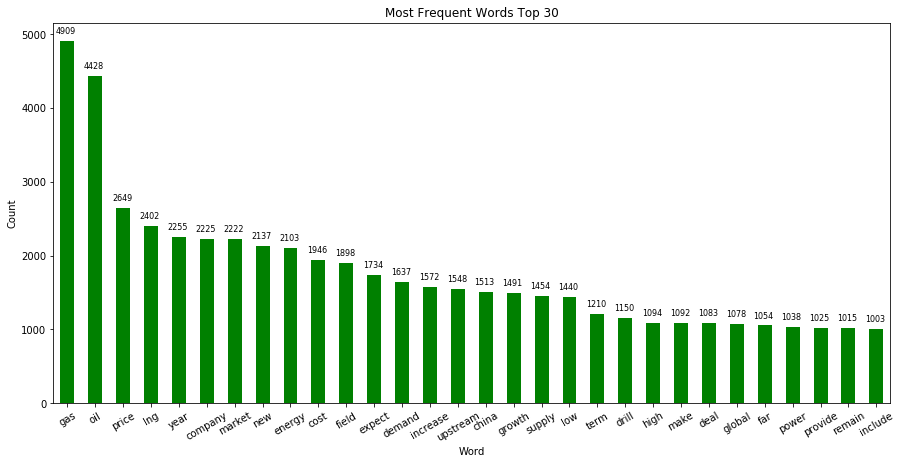

In [20]:
num_rank = 30
hist_freq_word(bow_all,num_rank)

<br>
<br>

### Visualize Bag of Words by Wordcloud

In [21]:
from wordcloud import WordCloud

In [22]:
def show_wordcloud(tfidf,keys_year):
    ''' Show Wordcloud Image for each year's Bag of Words '''
    i = 0
    fig = plt.figure(figsize=(14,14))
    for year in keys_year:
        fig.add_subplot(421 + i)
        wordcloud = WordCloud(background_color='white').generate_from_frequencies(tfidf[year])
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(year,fontsize=14)
        plt.axis('off')
        i += 1
    plt.tight_layout()
    plt.show()

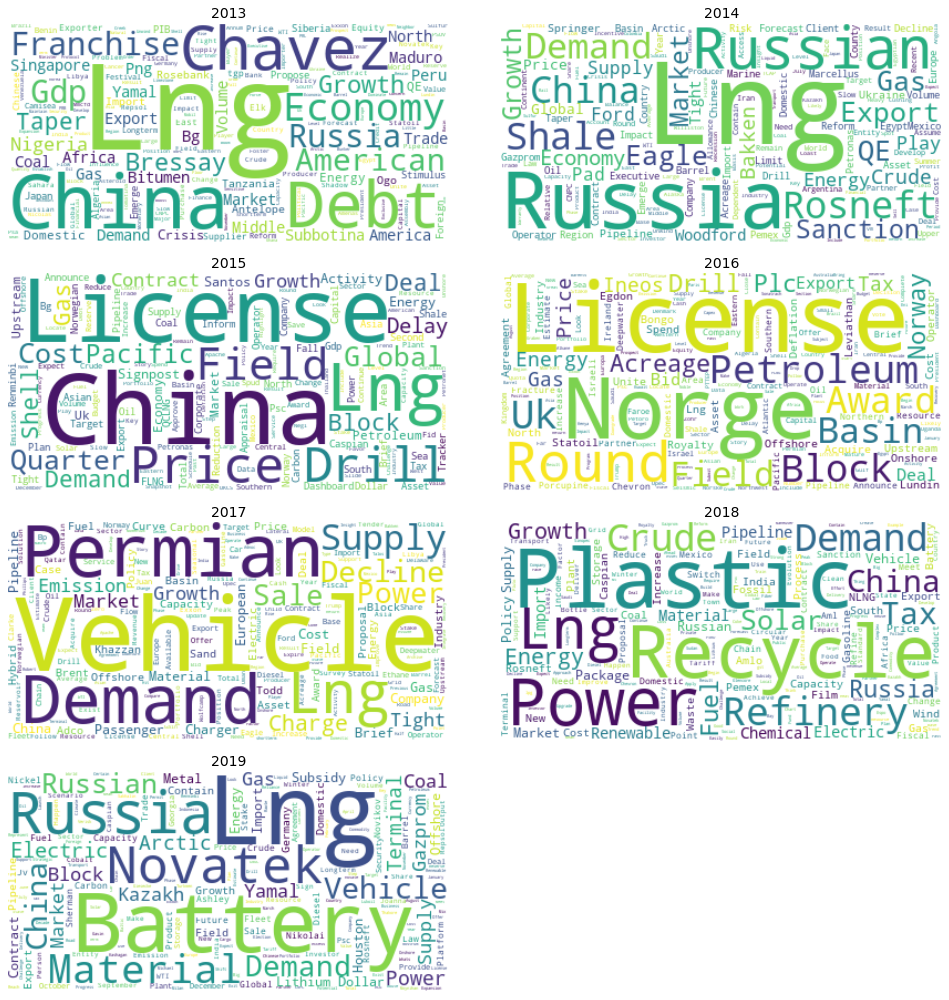

In [23]:
show_wordcloud(tfidf_rev,keys_year)

### Dimension Reduction by Principal Component Analysis to Visualize the Results

In [24]:
from sklearn.decomposition import PCA
pca = PCA().fit(vectors_year)
pc_year = pca.transform(vectors_year)
pc_article = pca.transform(vectors_article)
comp = pca.components_
EigenValue = pca.explained_variance_ratio_

In [25]:
def ScreePlot(EigenValue,ax_left,prmax,ls=None,mkr=None):
    ''' Scree plot to see the contribution of each principal component '''
    # Individual    
    x = np.arange(len(EigenValue)) + 1
    ax_left.plot(x, EigenValue*100,'b',linestyle=ls,marker=mkr,label='Eigen Value')
    ax_left.set_ylim([prmax['ymin1']-1,prmax['ymax1']+1])
    ax_left.set_xticks(np.arange(prmax['xmin'],prmax['xmax'] + 1e-6,prmax['xmajor']))
    ax_left.set_yticks(np.arange(prmax['ymin1'],prmax['ymax1'] + 1e-6,prmax['ymajor1']))    
    plt.grid(b=True, which='major',color='black',linestyle='-',linewidth=0.4,zorder=-2)
    plt.ylabel('Eigen Value [%]')
    plt.xlabel('Number of components')

    # Cumulative
    ratio_lr = (prmax['ymax2'] - prmax['ymin2'])/(prmax['ymax1'] - prmax['ymin1'])
    x_margin = prmax['xmajor']/10    
    ax_right = ax_left.twinx()
    ax_right.plot(x, np.cumsum(EigenValue)*100,'r',linestyle=ls,marker=mkr,label='Cumulative')
    ax_right.set_xlim([prmax['xmin']-x_margin,prmax['xmax']+x_margin])
    ax_right.set_ylim([prmax['ymin2']-ratio_lr,prmax['ymax2']+ratio_lr])
    ax_right.set_yticks(np.arange(prmax['ymin2'],prmax['ymax2'] + 1e-6,prmax['ymajor2']))    
    plt.ylabel('Cumulative Eigen Value [%]')
    plt.title('Scree Plot')
    lns = ax_left.get_lines() + ax_right.get_lines()
    labs = [l.get_label() for l in lns]
    plt.legend(lns,labs,loc='center right')
    plt.tight_layout(pad=1, w_pad=1.5)

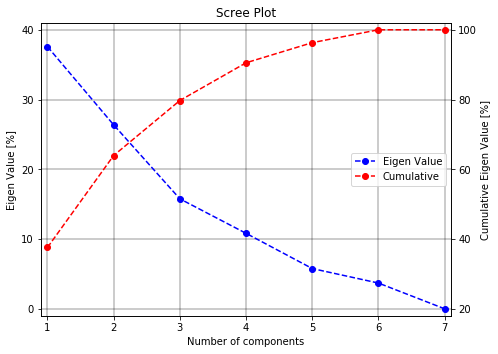

In [26]:
# Visualize Principal Components for each year and Scree plot
fig, ax = plt.subplots(figsize=(7,5))
prmax = {'xmin':1, 'xmax':7, 'xmajor':1,
         'ymin1':0,'ymax1':40, 'ymajor1':10,
         'ymin2':20,'ymax2':100,'ymajor2':20}
ScreePlot(EigenValue,ax,prmax,ls='--',mkr='o')
plt.show()

### Define "ness" vectors

In [27]:
def component_vector(words):
    vector = pd.np.zeros(300)
    for word in words:
        v = word_vectors[word]
        vector += v / len(words)
    return vector

In [28]:
def nessvector(target, components):
    ''' Create "ness" vector  '''
    target = word_vectors[target] if isinstance(target, str) else target
    vector = word_vectors.cosine_similarities(target, components.values)
    return pd.Series((vector - vector.mean()) / .15, index=components.index)

In [29]:
nessvector_keys = ['Environment','Americas','Downturn','Europe','Asia','Oil','Gas']
COMPONENT_WORDS = OrderedDict([
    (nessvector_keys[0], ('climate environment renewable nature solar').split()),
    (nessvector_keys[1], 'Americas America Latin_America Brazil Argentine US'.split()),
    (nessvector_keys[2], 'downturn recession'.split()),
    (nessvector_keys[3], 'Europe Norway UK Russia'.split()),
    (nessvector_keys[4], 'Japan China Southeast_Asia'.split()),
    (nessvector_keys[5], 'Oil Crude'.split()),
    (nessvector_keys[6], 'Gas lng'.split()),
])

components = pd.DataFrame([component_vector(words) for (component, words) in COMPONENT_WORDS.items()],
                          index=[component for (component, words) in COMPONENT_WORDS.items()])
pc_ness = pd.DataFrame()
for i in range(len(comp)):
    tmp = pd.DataFrame([nessvector(comp[i,:],components).values],
                       columns=nessvector_keys)
    pc_ness = pd.concat([pc_ness,tmp])

In [30]:
def pc_mat_importance(pc_ness,pca):
    ''' Visualize Principal Component-Feature Matrix by Heatmap '''
    # Sort by Eigen value of Prinicpal Component Analysis
    eigenvalues = pca.explained_variance_
    importance = eigenvalues/sum(eigenvalues)

    # Display Heat map
    fig, ax = plt.subplots(figsize=(10,4))
    ax = sns.heatmap(pc_ness,cmap='coolwarm', linewidth=0.5,
                     vmin=-1, vmax=1,cbar_kws={'label': 'Principal axes in feature space'})
    imp_pc_zip = sorted(zip(importance, np.arange(1,pca.n_components_+ 1, 1)), reverse=True)    
    idx_pc = ['PC'+str(i)+': '+'{:.1f}'.format(imp*100)+'%' for imp, i in imp_pc_zip]
    ax.set_yticklabels(idx_pc, rotation=0)
    plt.ylabel('Feature Importance sorted by PCA', fontsize=12)
    plt.show()

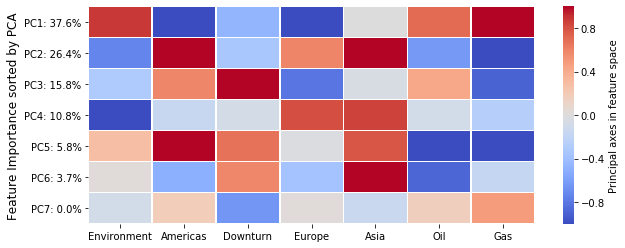

In [31]:
pc_mat_importance(pc_ness,pca)

In [32]:
def word2pc(bow_all,word_vectors,min_count):
    count = list(bow_all.values())
    words = list(bow_all.keys())[:np.argmax(np.where(np.array(count) > min_count))]
    vec_used = []
    words_used = []
    for word in words:
        try:
            vec_used.append(word_vectors.get_vector(word))
            words_used.append(word)
        except:
            pass;
    pc_words = pca.transform(vec_used)
    return pc_words,words_used

In [33]:
def ax_config_pc(idx_pc,ax):
    ax.set_xlabel('PC '+ str(idx_pc[0]+1))
    ax.set_ylabel('PC '+ str(idx_pc[1]+1))
    ax.patch.set_facecolor('#B5B5B5')
    plt.grid(b=True, which='minor',color='w',linestyle='--',linewidth=0.2,zorder=-1)
    plt.grid(b=True, which='major',color='w',linestyle='-',linewidth=0.5,zorder=-1)

In [34]:
def plot_pc(pc_year,pc_article,keys_year,year_article,idx_pc,words_used,vec_pc):
    ''' Plot 2 Principal Components '''
    fig=plt.figure(figsize=(14,6))
    cmap = pyl.cm.get_cmap('jet',len(keys_year))  # define the colormap
    cmaplist = [cmap(i) for i in range(cmap.N)]
    ax0 = fig.add_subplot(121)    
    for i,key in enumerate(keys_year):
        idx_plot = np.where(np.array(year_article) == int(key))
        ax0.scatter(pc_article[idx_plot,idx_pc[0]],pc_article[idx_plot,idx_pc[1]],
                    color=cmaplist[i],alpha=0.05)        
        ax0.scatter(pc_year[i,idx_pc[0]],pc_year[i,idx_pc[1]],color=cmaplist[i],
                    label=key,alpha=0.8,marker='o',zorder=3)
    ax0.set_xlim([-0.2,0.2]),ax0.set_ylim([-0.2,0.2])
    ax0.legend(loc='upper right')
    ax_config_pc(idx_pc,ax0)
    # Words that appeared in all the articles
    ax1 = fig.add_subplot(122)
    for i,word in enumerate(words_used):
        plt.scatter(vec_pc[i,idx_pc[0]],vec_pc[i,idx_pc[1]],s=0)
        plt.annotate(word,xy=(vec_pc[i,idx_pc[0]], vec_pc[i,idx_pc[1]]), xytext=(5, 2),
                     textcoords='offset points',ha='right',va='bottom',alpha=0.5)
    ax_config_pc(idx_pc,ax1)

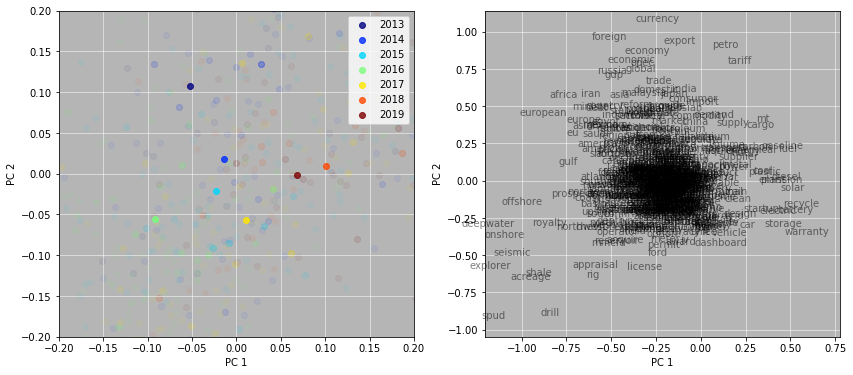

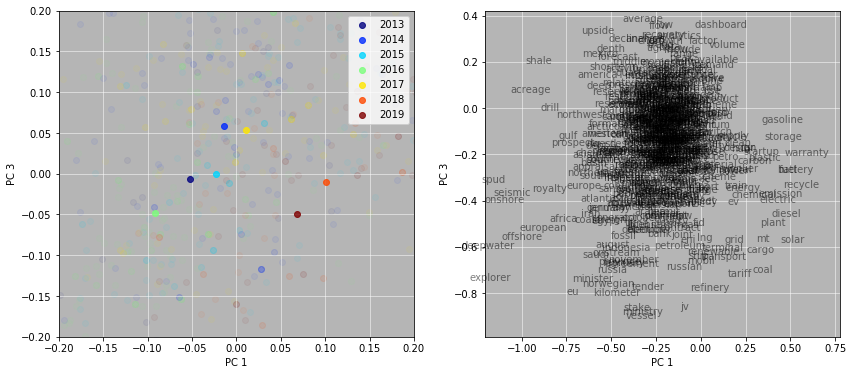

In [35]:
pc_words,words_used = word2pc(bow_all,word_vectors,min_count=100)
plot_pc(pc_year,pc_article,keys_year,year_article,[0,1],words_used,pc_words)
plot_pc(pc_year,pc_article,keys_year,year_article,[0,2],words_used,pc_words)